# LSTM - False Positives (of Kaggle)

In my aim to predict future solar cycles I have come across a common Kaggle problem, in which almost everyone claims to have solved the problem. 

Looking at the code at face value it does seem to be able to predict solar cycles to an insance level of accuracy. However, when we take a closer look at this code, we see that the reason it is so amazing at forecasting these cycles is because it uses the future dataset to do so!

In this notebook, take a look at the rnn_forecast at the end, and notice it uses all the datapoints to try and forecast future cycles. This is **cheating**!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
#tf.config.list_physical_devices()

2.11.0


## Defining functions for model training

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    # add extra dimension to 'series' for correct shape
    ds = tf.data.Dataset.from_tensor_slices(series)
    # 1D dataset
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # Shifts window 1 timestep at a time
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # Flattens nested windows into single dataset
    ds = ds.shuffle(shuffle_buffer)
    # Shuffles dataset to ensure training examples are presented in random order
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    # Applies function to each window in dataset
    return ds.batch(batch_size).prefetch(1)

In [3]:
# We can use this function to make some prediction by using the trained model 

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Preprocessing Data

In [4]:
df = pd.read_csv('../../Data/Savitzky-Golay Data/SVG_poly1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(74964, 2)


,Year,Sunspot_Number
0,1818.001,34.566570
1,1818.004,34.546053
2,1818.007,34.525535
3,1818.010,34.505017
4,1818.012,34.484499


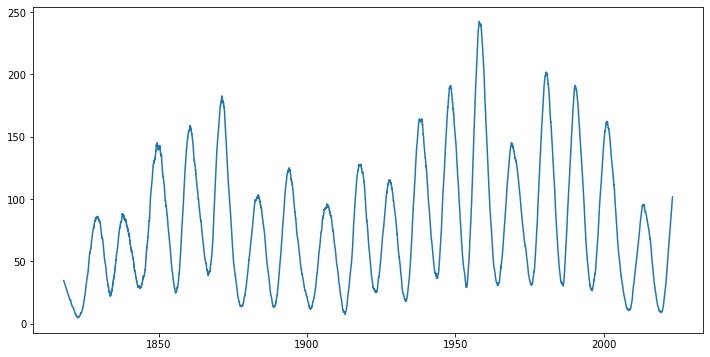

In [5]:
series = df['Sunspot_Number']
time = df['Year']

plt.figure(figsize=(12, 6))
plt.plot(time, series);

In [6]:
split_time = 60000
skips = 20
time_train = time[:split_time:skips]
y_train = series[:split_time:skips]
time_valid = time[split_time::skips]
y_valid = series[split_time::skips]

y_train

0         34.566570
20        34.156216
40        33.745862
60        33.335507
80        32.925153
            ...    
59900    167.683778
59920    165.042437
59940    163.580424
59960    162.341547
59980    161.952772
Name: Sunspot_Number, Length: 3000, dtype: float64

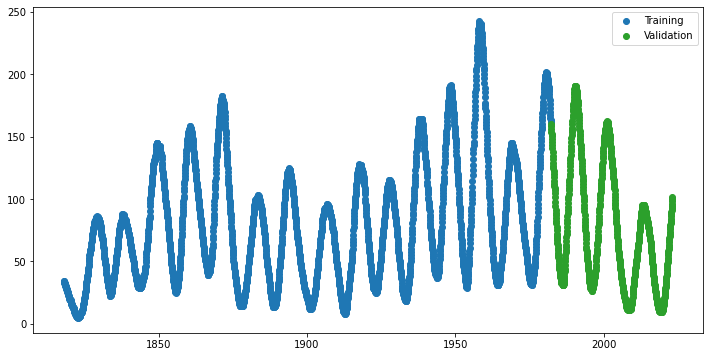

In [7]:
plt.figure(figsize=(12, 6))
plt.scatter(time_train, y_train, color='tab:blue', label='Training')
plt.scatter(time_valid, y_valid, color='tab:green', label='Validation')
plt.legend();

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(41)
np.random.seed(41)

shuffle_buffer_size = 100
window_size = 365*8 # How do I choose the optimum size?
batch_size = 64*1000

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)
print(y_train.shape)

(3000,)


## Determining the optimum learning rate

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss = tf.keras.losses.MSE

In [33]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(1, activation= 'sigmoid'),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 151.2376 - mse: 26454.4043 - lr: 1.0000e-08
Epoch 2/200
1/1 [==============================] - 1s 956ms/step - loss: 151.1614 - mse: 26434.1055 - lr: 1.1220e-08
Epoch 3/200
1/1 [==============================] - 1s 882ms/step - loss: 151.1472 - mse: 26435.9629 - lr: 1.2589e-08
Epoch 4/200
1/1 [==============================] - 1s 912ms/step - loss: 151.1576 - mse: 26433.9863 - lr: 1.4125e-08
Epoch 5/200
1/1 [==============================] - 1s 859ms/step - loss: 151.1296 - mse: 26424.9434 - lr: 1.5849e-08
Epoch 6/200
1/1 [==============================] - 1s 910ms/step - loss: 151.1141 - mse: 26417.8594 - lr: 1.7783e-08
Epoch 7/200
1/1 [==============================] - 1s 893ms/step - loss: 151.0957 - mse: 26413.6836 - lr: 1.9953e-08
Epoch 8/200
1/1 [==============================] - 1s 889ms/step - loss: 151.1091 - mse: 26420.8027 - lr: 2.2387e-08
Epoch 9/200
1/1 [==============================] - 1s 872ms/step - 

(1e-08, 0.001, 0.0, 200.0)

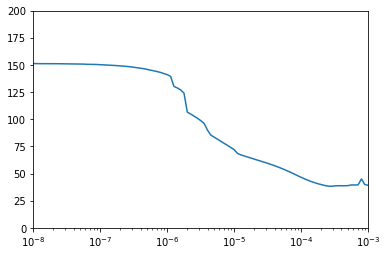

In [34]:
# Let's visualize "learning rate" vs "loss"
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 200])

Optimal learning rate ~ $10^{-6}$

## Training the Model

In [42]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

tf.keras.backend.clear_session()
tf.random.set_seed(41)
np.random.seed(41)

# Define the callback
checkpoint_path = "model_checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True, # Save only the model weights, not the entire model
    save_best_only=True, # Save only the best model, based on validation loss
    monitor='val_loss', # Monitor the validation loss
    mode='min', # The lower the better
    verbose=1 # Print a message when a checkpoint is saved
)

shuffle_buffer_size = 100
window_size = 365*8 # How do I choose the optimum size?
batch_size = 64*1000

train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.MSE

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(1, activation= 'sigmoid'),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

# Train the model with checkpointing
history = model.fit(train_set, epochs=200)#, callbacks=[checkpoint_callback])

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 21332.3750 - mse: 21332.3750
Epoch 2/200
1/1 [==============================] - 1s 870ms/step - loss: 21252.0762 - mse: 21252.0742
Epoch 3/200
1/1 [==============================] - 1s 859ms/step - loss: 21184.2559 - mse: 21184.2559
Epoch 4/200
1/1 [==============================] - 1s 908ms/step - loss: 21105.7168 - mse: 21105.7168
Epoch 5/200
1/1 [==============================] - 1s 947ms/step - loss: 21026.6953 - mse: 21026.6953
Epoch 6/200
1/1 [==============================] - 1s 889ms/step - loss: 20946.5684 - mse: 20946.5684
Epoch 7/200
1/1 [==============================] - 1s 876ms/step - loss: 20870.9297 - mse: 20870.9297
Epoch 8/200
1/1 [==============================] - 1s 874ms/step - loss: 20795.8223 - mse: 20795.8223
Epoch 9/200
1/1 [==============================] - 1s 914ms/step - loss: 20717.6074 - mse: 20717.6074
Epoch 10/200
1/1 [==============================] - 1s 890ms/step - loss: 20644.4062 

In [52]:
history = model.fit(train_set, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 7141.6812 - mse: 7141.6816
Epoch 2/1000
1/1 [==============================] - 1s 874ms/step - loss: 7140.5752 - mse: 7140.5752
Epoch 3/1000
1/1 [==============================] - 1s 837ms/step - loss: 7140.2275 - mse: 7140.2271
Epoch 4/1000
1/1 [==============================] - 1s 962ms/step - loss: 7137.3960 - mse: 7137.3960
Epoch 5/1000
1/1 [==============================] - 1s 857ms/step - loss: 7136.8579 - mse: 7136.8579
Epoch 6/1000
1/1 [==============================] - 1s 855ms/step - loss: 7134.7124 - mse: 7134.7129
Epoch 7/1000
1/1 [==============================] - 1s 873ms/step - loss: 7134.3525 - mse: 7134.3525
Epoch 8/1000
1/1 [==============================] - 1s 854ms/step - loss: 7131.6758 - mse: 7131.6758
Epoch 9/1000
1/1 [==============================] - 1s 842ms/step - loss: 7130.3525 - mse: 7130.3521
Epoch 10/1000
1/1 [==============================] - 1s 844ms/step - loss: 7128.2578 - mse: 71

In [ ]:
history = model.fit(train_set, epochs=2000)
plt.semilogx(history.history["loss"]);

Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 2699.6052 - mse: 2699.6052
Epoch 2/2000
1/1 [==============================] - 1s 869ms/step - loss: 2713.6912 - mse: 2713.6909
Epoch 3/2000
1/1 [==============================] - 1s 875ms/step - loss: 2704.5876 - mse: 2704.5876
Epoch 4/2000
1/1 [==============================] - 1s 881ms/step - loss: 2721.6450 - mse: 2721.6450
Epoch 5/2000
1/1 [==============================] - 1s 864ms/step - loss: 2701.8123 - mse: 2701.8123
Epoch 6/2000
1/1 [==============================] - 1s 875ms/step - loss: 2707.6521 - mse: 2707.6521
Epoch 7/2000
1/1 [==============================] - 1s 938ms/step - loss: 2716.0649 - mse: 2716.0649
Epoch 8/2000
1/1 [==============================] - 1s 864ms/step - loss: 2708.5603 - mse: 2708.5601
Epoch 9/2000
1/1 [==============================] - 1s 853ms/step - loss: 2711.5085 - mse: 2711.5085
Epoch 10/2000
1/1 [==============================] - 1s 857ms/step - loss: 2707.6411 - mse: 27

In [38]:
'''
predictions = []
rnn_forecasts = []
rnn_forecasts.append(model_forecast(model, series[..., np.newaxis], window_size))
predictions.append(rnn_forecasts[0][-1])
for i in range(5):
    rnn_forecasts.append(model_forecast(model, rnn_forecasts[i][0, -window_size:, 0], window_size))
    predictions.append(rnn_forecasts[i+1][-1])
'''

'\npredictions = []\nrnn_forecasts = []\nrnn_forecasts.append(model_forecast(model, series[..., np.newaxis], window_size))\npredictions.append(rnn_forecasts[0][-1])\nfor i in range(5):\n    rnn_forecasts.append(model_forecast(model, rnn_forecasts[i][0, -window_size:, 0], window_size))\n    predictions.append(rnn_forecasts[i+1][-1])\n'

In [39]:
rnn_forecast = model_forecast(model, series[-window_size:, np.newaxis], window_size)
rnn_forecast2 = model_forecast(model, rnn_forecast[0, -window_size:, 0], window_size)
rnn_forecast3 = model_forecast(model, rnn_forecast2[0, -window_size:, 0], window_size)
#rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

<ipython-input-39-9ba9218dd0c9>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rnn_forecast = model_forecast(model, series[-window_size:, np.newaxis], window_size)


1/1 [==============================] - 0s 111ms/step


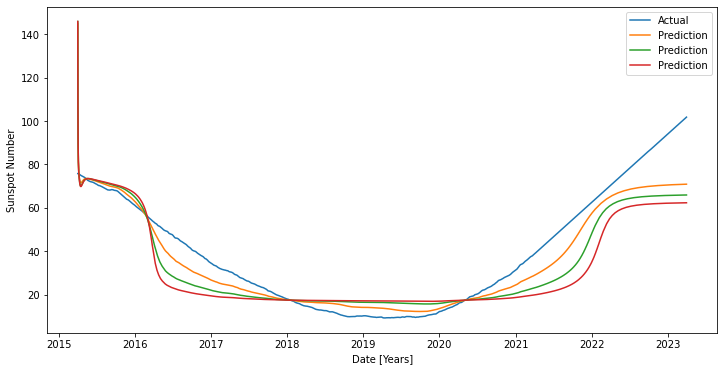

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(time[-window_size:], series[-window_size:], label='Actual')
plt.plot(time[-window_size:], rnn_forecast[0, :, 0], label='Prediction')
plt.plot(time[-window_size:], rnn_forecast2[0, :, 0], label='Prediction')
plt.plot(time[-window_size:], rnn_forecast3[0, :, 0], label='Prediction')
plt.xlabel('Date [Years]')
plt.ylabel('Sunspot Number')
plt.legend();

#### Comment on plot:

This prediction is outstanding... because it has **seen** the data!

In [ ]:
# Standard Deviation 
std_data = np.std(series[split_time:])
std_fc = np.std(rnn_forecast)

normalised_std_data = np.array(std_data / np.mean(series[split_time:]))
normalised_std_fc = np.array(std_fc / np.mean(rnn_forecast))

# Correlation
correlation = np.array(np.corrcoef(series[split_time:], rnn_forecast)[0, 1])

print(f'The normalised standard deviation of the data is {normalised_std_data:.3f}')
print(f'The normalised standard deviation of the forecast is {normalised_std_fc:.3f}, and the correlation is {correlation:.3f}.')